# Moderna Market Forecasting

## Meet our Team
* Snigdha Chigurupati
* Arushi Agarwal
* Akshitha Kukudala

## Aim :
To forecast the sales for the most consistently profitable Moderna Market.

## Time Series Analysis Flow

1. Import the required libraries, MRNA data download from yfinance
2. Understanding the data
3. Decomposing Moderna Corporation data into its trend, seasonal, and residual components
4. Observing the stationarity of the series by ADF and KPSS
5. Data Preparation - If NULL hypothesis is rejected, finding the differencing
6. Build and Evaluate Time Series Forecast by MA, AR, ARMA, ARIMA

In [65]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10,6)
import datetime
import yfinance as yf
import warnings
warnings.filterwarnings('ignore')

In [66]:
stock = 'MRNA'
start = datetime.datetime(2020,1, 1)
end = datetime.datetime(2022,1, 1)
mrna_close = yf.download(stock, start=start, end=end, interval= '1d')['Close']

[*********************100%***********************]  1 of 1 completed


In [67]:
mrna_close.head()

Date
2020-01-02    19.230000
2020-01-03    18.889999
2020-01-06    18.129999
2020-01-07    17.780001
2020-01-08    17.980000
Name: Close, dtype: float64

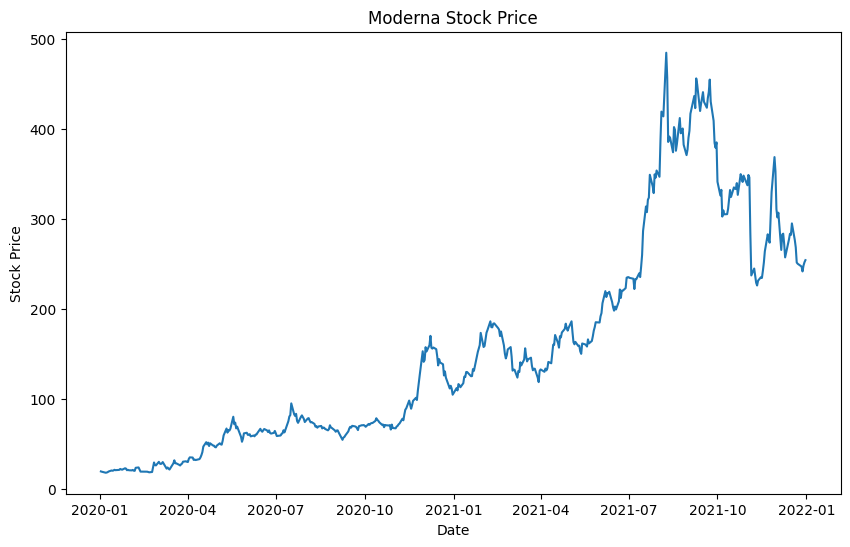

In [68]:
plt.figure(figsize=(10, 6))
plt.plot(mrna_close)
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('Moderna Stock Price')
plt.show()

In [69]:
from statsmodels.tsa.seasonal import seasonal_decompose

We are now decomposing a time series data of the daily closing prices of the stock for Moderna into its 
* trend, 
* seasonal, and 
* residual components using an additive model with a periodicity of 7 days (weekly seasonality).

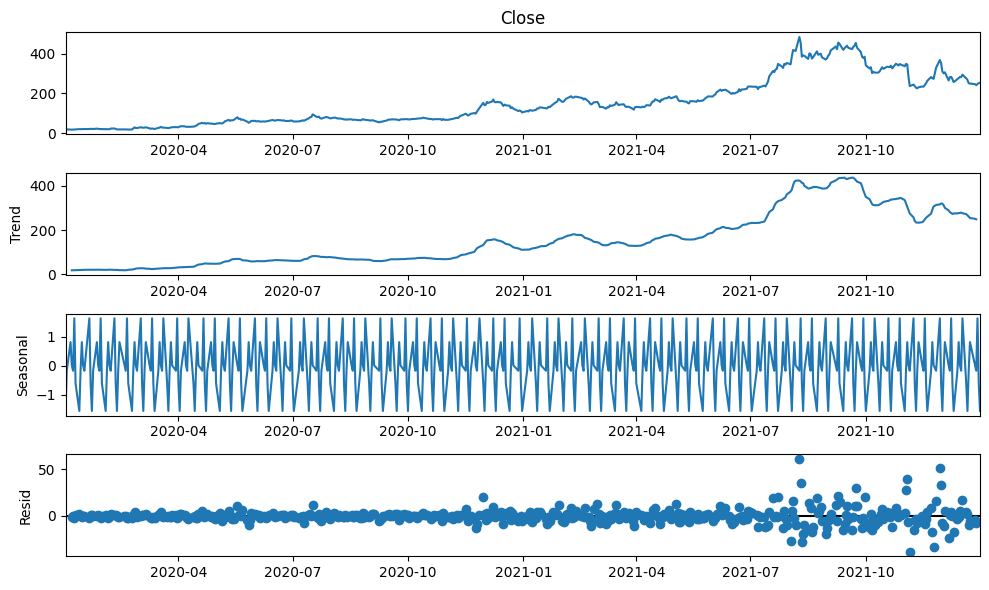

In [70]:
decomposition = seasonal_decompose(mrna_close, model='additive', period=7)
decomposition.plot()
plt.show()

In [71]:
mrna_close = pd.DataFrame(mrna_close)
mrna_close.isnull().sum()

Close    0
dtype: int64

In [72]:
mrna_diff = mrna_close['Close'].diff().dropna()

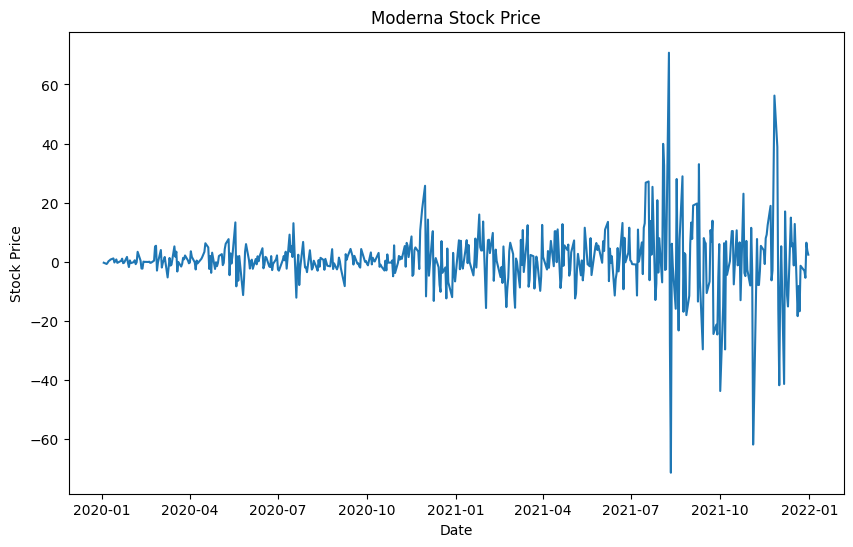

In [73]:
plt.figure(figsize=(10, 6))
plt.plot(mrna_diff)
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('Moderna Stock Price')
plt.show()

Observing the stationarity of the series

## Kwiatkowski–Phillips–Schmidt–Shin (KPSS) Test
* These tests are used for testing a NULL Hypothesis (HO) that will perceive the time series as stationary around a deterministic trend against the alternative of a unit root. 


In [74]:
from statsmodels.tsa.stattools import kpss
#Apply the KPSS test to the data
kpss_stat, p_value, lags, critical_values = kpss(mrna_close['Close'])
print('KPSS Test statistic is {} and p-value is {}'.format(kpss_stat, p_value))

KPSS Test statistic is 3.0901908870293 and p-value is 0.01


In [75]:
kpss_stat, p_value, lags, critical_values = kpss(mrna_diff)
print('KPSS Test statistic is {} and p-value is {}'.format(kpss_stat, p_value))

KPSS Test statistic is 0.07053871857176994 and p-value is 0.1


## Augmented Dickey-Fuller (ADF) Test or Unit Root Test
* The ADF test is the most popular statistical test. It is done with the following assumptions:

* Null Hypothesis (H0): Series is non-stationary
* Alternate Hypothesis (HA): Series is stationary
* p-value >0.05 Fail to reject (H0)
* p-value <= 0.05 Accept (H1)

In [76]:
from statsmodels.tsa.stattools import adfuller
stat_test = adfuller(mrna_close['Close'])

In [77]:
from statsmodels.tsa.stattools import adfuller
stat_test = adfuller(mrna_close['Close'])
print('Test statistic is {} and p-value is {}'.format(stat_test[0],stat_test[1]))

Test statistic is -0.9835718399077913 and p-value is 0.7592088393380902


In [78]:
stat_test_diff = adfuller(mrna_diff)
print('The test statistics is {} and p-value is {}'.format(stat_test_diff[0], stat_test_diff[1]))

The test statistics is -6.926287414953981 and p-value is 1.1131622944168888e-09


After taking the first difference,  the time series became stationary.

In [79]:
train_len = int(len(mrna_close)*0.8)
train = mrna_close[:train_len]
test = mrna_close[train_len:]

## Moving Average

`Moving average`model tries to capture the time series dynamics simply by error terms. Let $e_t$ is a normally distributed term, meaning that it is identically and independently distributed (iid). So, unlike AR, MA is alway stationary.

In [80]:
from statsmodels.tsa.arima.model import ARIMA

In [81]:
mrna_diff = mrna_close['Close'].diff().dropna()

In [82]:
mrna_diff.head(5)

Date
2020-01-03   -0.340000
2020-01-06   -0.760000
2020-01-07   -0.349998
2020-01-08    0.199999
2020-01-09    0.420000
Name: Close, dtype: float64

In [83]:
diff_train_len = int(len(mrna_diff) * 0.8)
diff_train = mrna_diff[:diff_train_len]
diff_test = mrna_diff[diff_train_len:]

In [84]:
start = len(diff_train)
end = len(diff_train) + len(diff_test) - 1

In [85]:
ma_model = ARIMA(diff_train, order=(0, 0, 8))
ma_results = ma_model.fit()

In [86]:
ma_pred = ma_results.predict(start, end)
ma_pred.index = diff_test.index

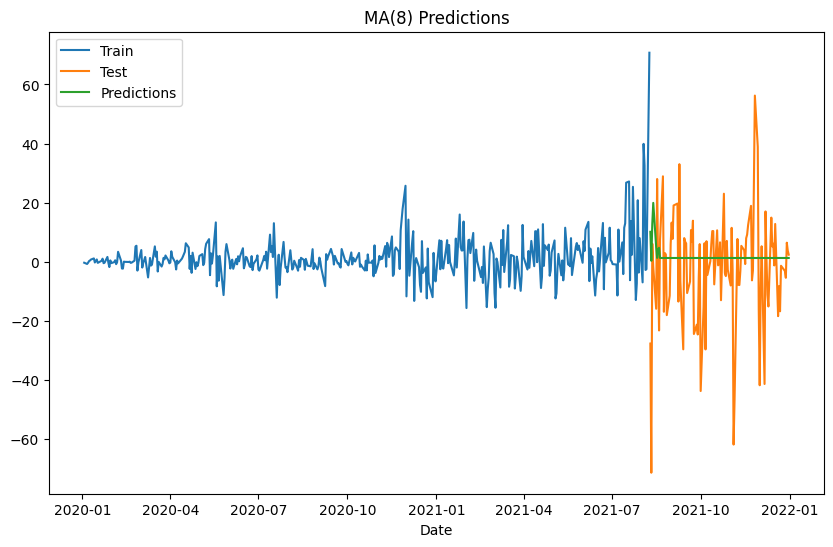

In [87]:
plt.figure(figsize=(10, 6))
plt.plot(diff_train, label='Train')
plt.plot(diff_test, label='Test')
plt.plot(ma_pred, label='Predictions')
plt.title('MA(8) Predictions')
plt.legend()
plt.xlabel('Date')
plt.show()

In [88]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [89]:
mae_ma = mean_absolute_error(diff_test, ma_pred)
mse_ma = mean_squared_error(diff_test, ma_pred)
rmse_ma = np.sqrt(mean_squared_error(diff_test, ma_pred))

In [90]:
ma_perf = {'mae_ma': mae_ma, 'mse_ma': mse_ma,
'rmse_ma': rmse_ma}
ma_perf = pd.DataFrame([ma_perf])
ma_perf

,mae_ma,mse_ma,rmse_ma
0,13.952789,383.823374,19.591411


In [91]:
forecast_index = pd.date_range(diff_test.index[-1], periods=15)

In [92]:
ma_model = ARIMA(mrna_diff, order =(0,0,8))
ma_result = ma_model.fit()
ma_forecast = ma_result.forecast(steps=15)
ma_forecast.index = forecast_index

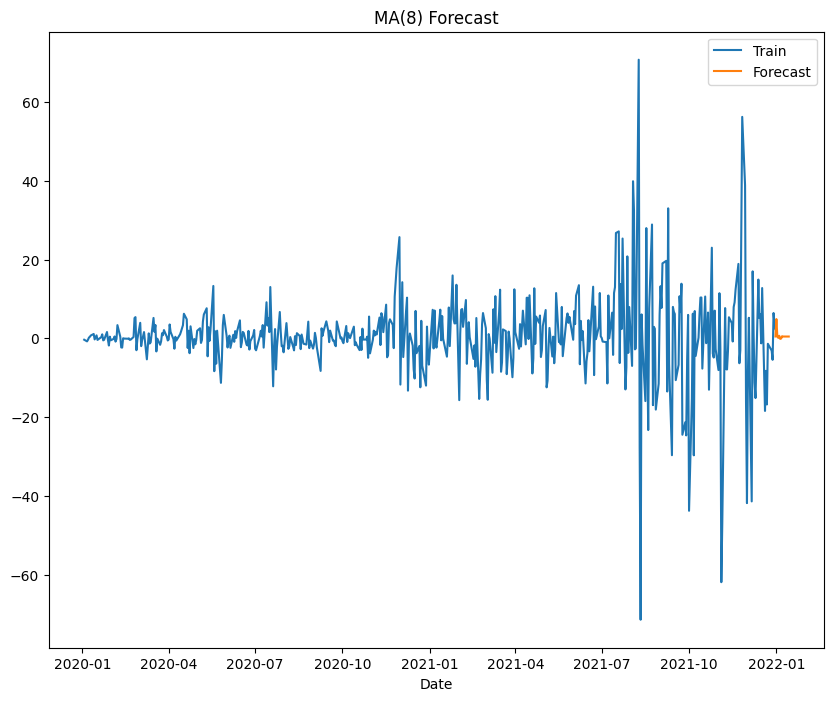

In [93]:
plt.figure(figsize=(10, 8))
plt.title('MA(8) Forecast')
plt.plot(mrna_diff, label='Train')
plt.plot(ma_forecast, label='Forecast')
plt.xlabel('Date')
plt.legend()
plt.show()

## Autoregressive Model

In [94]:
ar_model = ARIMA(diff_train, order= (8, 0, 0))
ar_result = ar_model.fit()

In [95]:
ar_pred = ar_result.predict(start, end)
ar_pred.index = diff_test.index

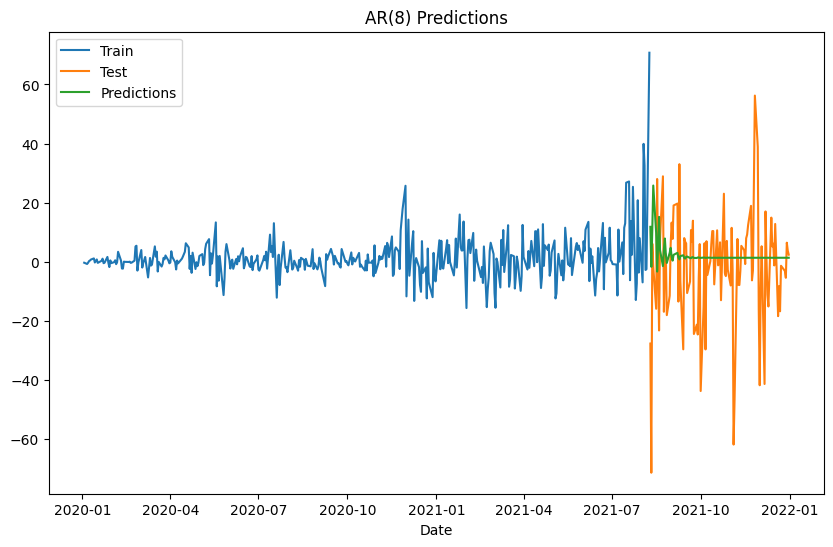

In [96]:
plt.figure(figsize=(10, 6))
plt.plot(diff_train, label='Train')
plt.plot(diff_test, label='Test')
plt.plot(ar_pred, label='Predictions')
plt.title('AR(8) Predictions')
plt.legend()
plt.xlabel('Date')
plt.show()

In [97]:
mae_ar = mean_absolute_error(diff_test, ar_pred)
mse_ar = mean_squared_error(diff_test, ar_pred)
rmse_ar = np.sqrt(mean_squared_error(diff_test, ar_pred))

In [98]:
ar_perf = {'mae_ar':mae_ar, 'mse_ar':mse_ar,
          'rmse_ar': rmse_ar}
ar_perf = pd.DataFrame([ar_perf])
ar_perf

,mae_ar,mse_ar,rmse_ar
0,14.222321,399.655007,19.991373


In [99]:
ma_perf

,mae_ma,mse_ma,rmse_ma
0,13.952789,383.823374,19.591411


In [100]:
ar_model = ARIMA(mrna_diff, order= (8, 0, 0))
ar_result = ar_model.fit()
ar_forecast = ar_result.forecast(steps=15)

In [101]:
ar_forecast.index = forecast_index

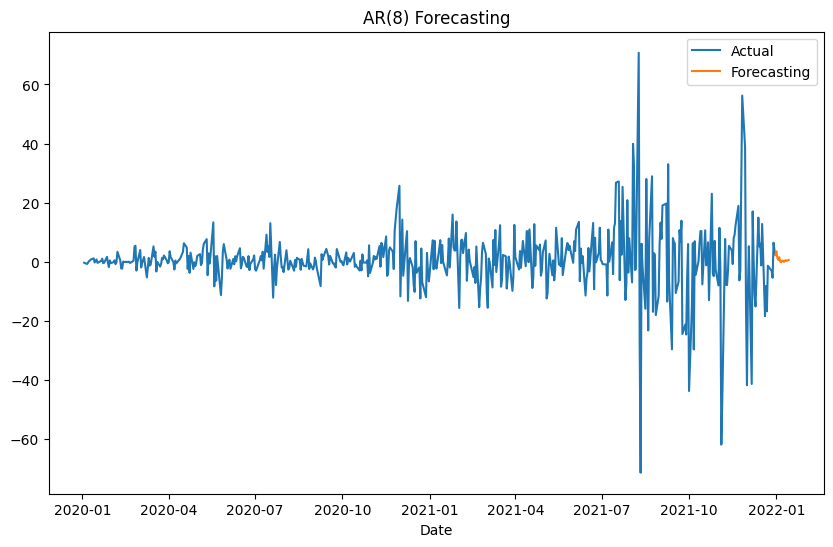

In [102]:
plt.figure(figsize=(10, 6))
plt.plot(mrna_diff, label='Actual')
plt.plot(ar_forecast, label='Forecasting')
plt.title('AR(8) Forecasting')
plt.legend()
plt.xlabel('Date')
plt.show()

## Autoregressive Moving Average

In [103]:
from statsmodels.tsa.arima.model import ARIMA

In [104]:
arma_model  = ARIMA(diff_train, order = (8, 0, 8))
arma_result = arma_model.fit()

In [105]:
arma_pred = arma_result.predict(start, end)
arma_pred.index = diff_test.index

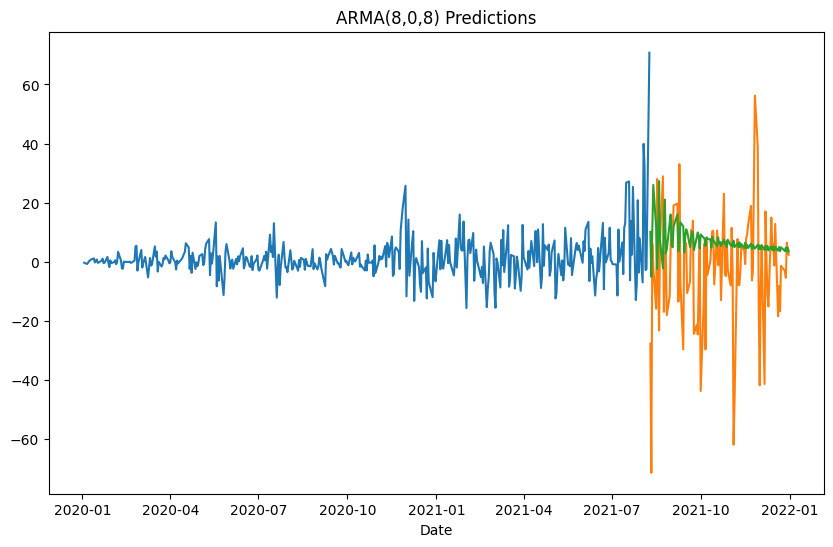

In [106]:
plt.figure(figsize=(10, 6))
plt.plot(diff_train, label='Train')
plt.plot(diff_test, label='Test')
plt.plot(arma_pred, label='Prediction')
plt.title('ARMA(8,0,8) Predictions')
plt.xlabel('Date')
plt.show()

In [107]:
mae_arma = mean_absolute_error(diff_test, arma_pred)
mse_arma = mean_squared_error(diff_test, arma_pred)
rmse_arma = np.sqrt(mean_squared_error(diff_test, arma_pred))

In [108]:
arma_perf = {'mae_arma': mae_arma, 'mse_arma': mse_arma,
'rmse_arma': rmse_arma}
arma_perf = pd.DataFrame([arma_perf])
arma_perf

,mae_arma,mse_arma,rmse_arma
0,15.22513,467.252927,21.616034


In [109]:
arma_model  = ARIMA(mrna_diff, order = (8, 0, 8))
arma_result = arma_model.fit()
arma_forecast = arma_result.forecast(steps=15)
arma_forecast.index = forecast_index

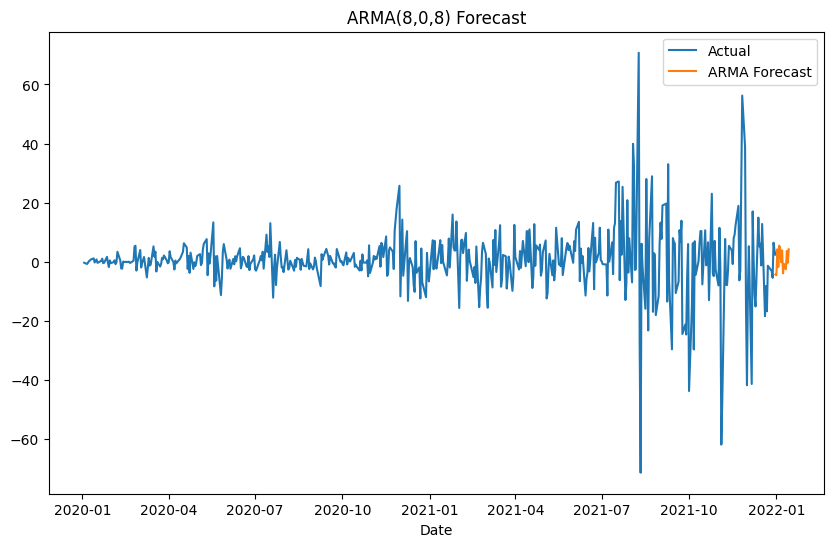

In [110]:
plt.figure(figsize=(10, 6))
plt.plot(mrna_diff, label='Actual')
plt.plot(arma_forecast, label='ARMA Forecast')
plt.title('ARMA(8,0,8) Forecast')
plt.xlabel('Date')
plt.legend()
plt.show()

## Autoregressive Integrated Moving Average

In [111]:
arima_model = ARIMA(train, order=(8, 1, 8))#p: order of AR, I: Integration, q: order of MA
arima_result = arima_model.fit()

In [112]:
arima_predict = arima_result.predict(start, end)
arima_predict.index = diff_test.index

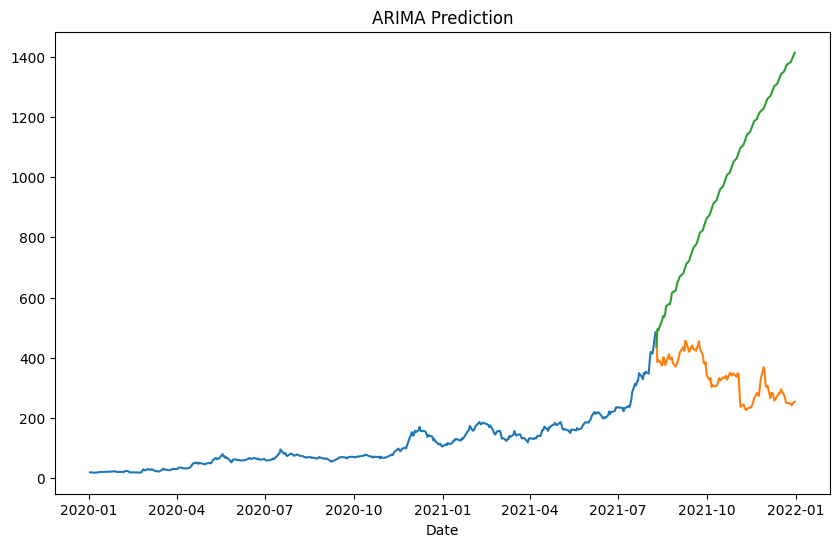

In [113]:
plt.figure(figsize=(10,6))
plt.plot(train, label='Train')
plt.plot(test, label='Test')
plt.plot(arima_predict, label='Prediction')
plt.title('ARIMA Prediction')
plt.xlabel('Date')
plt.show()

In [114]:
arima_pred_diff = arima_predict.diff().dropna()

In [115]:
mae_arima = mean_absolute_error(diff_test.iloc[1:], arima_pred_diff)
mse_arima = mean_squared_error(diff_test.iloc[1:], arima_pred_diff)
rmse_arima = np.sqrt(mean_squared_error(diff_test.iloc[1:], arima_pred_diff))

In [116]:
arima_perf = {'mae_arima': mae_arima, 'mse_arima': mse_arima,
'rmse_arima': rmse_arima}
arima_perf = pd.DataFrame([arima_perf])
arima_perf

,mae_arima,mse_arima,rmse_arima
0,16.362085,595.815639,24.409335


In [117]:
arima_model  = ARIMA(mrna_close, order = (8, 1, 8))
arima_result = arima_model.fit()
arima_forecast = arima_result.forecast(steps=15)
arima_forecast.index = forecast_index

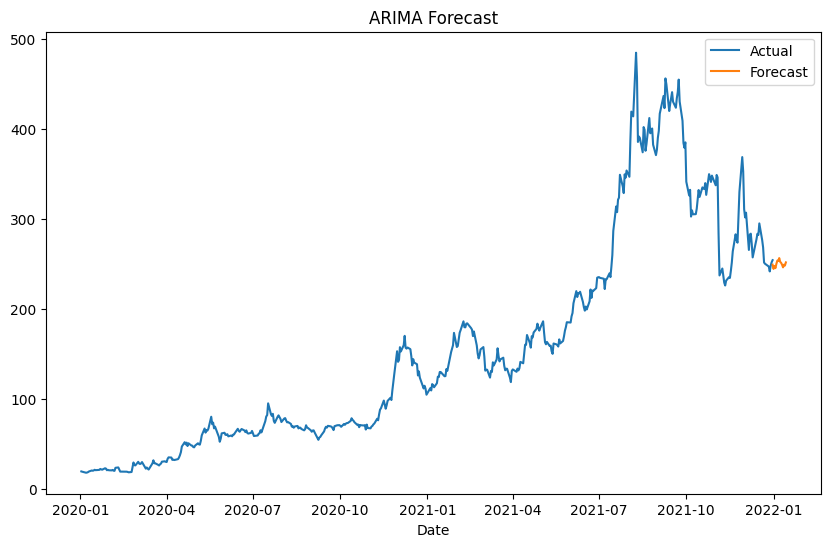

In [118]:
plt.figure(figsize=(10,6))
plt.plot(mrna_close, label='Actual')
plt.plot(arima_forecast, label='Forecast')
plt.title('ARIMA Forecast')
plt.xlabel('Date')
plt.legend()
plt.show()

In [119]:
ma_perf

,mae_ma,mse_ma,rmse_ma
0,13.952789,383.823374,19.591411


In [120]:
ar_perf

,mae_ar,mse_ar,rmse_ar
0,14.222321,399.655007,19.991373


In [121]:
arma_perf

,mae_arma,mse_arma,rmse_arma
0,15.22513,467.252927,21.616034


In [122]:
arima_perf

,mae_arima,mse_arima,rmse_arima
0,16.362085,595.815639,24.409335


Conclusion : On basis of models built for forecasting the sales of the time series data, show that:
MA is the best for forecasting the sales for the Moderna data.
